In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, Activation,Lambda,Multiply
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy,MeanSquaredError
from tensorflow.keras.utils import to_categorical

In [2]:
data = pd.read_csv("D:/过渡/zj/深度学习模型/TCGA训练集.csv")

data['target'] = data['ssrisk'].map({'low': 0, 'high': 1})
data


,Unnamed: 0,MPEG1,PLAUR,score,risk,ssrisk,target
0,TCGA-B2-4101-01A,4.722377,2.177188,0.046879,low,high,1
1,TCGA-BP-4342-01A,3.653921,2.454409,0.502013,high,low,0
2,TCGA-B0-4691-01A,2.396380,2.848564,1.078755,high,low,0
3,TCGA-BP-4167-01A,4.328305,2.513032,0.356070,high,high,1
4,TCGA-B8-4620-01A,3.964925,4.708160,1.781872,high,high,1
...,...,...,...,...,...,...,...
602,TCGA-CJ-6033-01A,3.307191,3.226849,1.062610,high,high,1
603,TCGA-BP-4782-01A,4.043296,2.245836,0.271084,low,high,1
604,TCGA-CJ-4895-01A,3.630476,2.888714,0.771074,high,high,1
605,TCGA-CJ-4640-01A,4.821768,2.138237,-0.003422,low,high,1


In [4]:
#分离特征和标签
X = data.iloc[:,[1,2]]
y = data.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.1,random_state=12,stratify = y, shuffle=True)#
print(X_train.shape)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# y_train = to_categorical(y_train)
# y_valid = to_categorical(y_valid)

# X_train_tensor = torch.tensor(X_train.values,dtype = torch.float32)
# y_valid_tensor = torch.tensor(y_valid.values,dtype = torch.float32)

(546, 2)


In [5]:
data2 = pd.read_csv("GSE36895验证集.csv")
data2['target'] = data2['ssrisk'].map({'low': 0, 'high': 1})

X = data2.iloc[:,[1,2]]
y = data2.iloc[:,-1]

X_test = data2.iloc[:,[1,2]]
y_test = data2.iloc[:,-1]
X_test = scaler.fit_transform(X_test)
# X_test_tensor = torch.tensor(X_test.values,dtype = torch.float32)
# y_test_tensor = torch.tensor(y_test.values,dtype = torch.float32)

In [6]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    
#     attention = Dense(32)(inputs)
#     attention = Activation('relu')(attention)  # 使用小写的'relu'
    attention = Dense(16)(inputs)
    attention = Activation('relu')(attention)  # 使用小写的'relu'
    attention = Dense(8)(attention)
    attention = Activation('relu')(attention)
    attention = Dense(1)(attention)
    attention_weights = Activation('sigmoid')(attention)
    
    
    weighted_features = inputs * attention_weights
    
    
    # 分类器
    x = Dropout(0.5)(weighted_features)
    x = BatchNormalization()(x)
    x = Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = LeakyReLU()(x)
    x = Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = LeakyReLU()(x)
    outputs = Dense(1, activation='sigmoid')(x)  # 输出单个值，使用sigmoid激活函数
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (X_train.shape[1],)
model = build_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.0005), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 定义 ModelCheckpoint 回调
checkpoint = ModelCheckpoint(
    'best_model2.h5',  # 模型文件的保存路径
    monitor='val_accuracy',  # 监控的指标
    save_best_only=True,  # 仅保存最佳模型
    mode='max',  # 最大化 val_accuracy
    verbose=1  # 输出保存的日志信息
)

# 训练模型时使用 ModelCheckpoint 回调
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint]
)

Epoch 1/100
31/35 [=========================>....] - ETA: 0s - loss: 0.8554 - accuracy: 0.4577
Epoch 1: val_accuracy improved from -inf to 0.75410, saving model to best_model2.h5
35/35 [==============================] - 3s 22ms/step - loss: 0.8529 - accuracy: 0.4707 - val_loss: 0.8259 - val_accuracy: 0.7541
Epoch 2/100
34/35 [============================>.] - ETA: 0s - loss: 0.8287 - accuracy: 0.5147
Epoch 2: val_accuracy improved from 0.75410 to 0.83607, saving model to best_model2.h5
35/35 [==============================] - 0s 7ms/step - loss: 0.8285 - accuracy: 0.5165 - val_loss: 0.7895 - val_accuracy: 0.8361
Epoch 3/100
31/35 [=========================>....] - ETA: 0s - loss: 0.8027 - accuracy: 0.5988
Epoch 3: val_accuracy did not improve from 0.83607
35/35 [==============================] - 0s 5ms/step - loss: 0.8036 - accuracy: 0.6081 - val_loss: 0.7613 - val_accuracy: 0.8197
Epoch 4/100
32/35 [==========================>...] - ETA: 0s - loss: 0.7872 - accuracy: 0.6426
Epoch 4: v

Epoch 30/100
35/35 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.6502
Epoch 30: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6694 - accuracy: 0.6502 - val_loss: 0.5990 - val_accuracy: 0.8197
Epoch 31/100
20/35 [================>.............] - ETA: 0s - loss: 0.6371 - accuracy: 0.7094
Epoch 31: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6960 - val_loss: 0.5935 - val_accuracy: 0.8197
Epoch 32/100
33/35 [===========================>..] - ETA: 0s - loss: 0.6700 - accuracy: 0.6364
Epoch 32: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 5ms/step - loss: 0.6694 - accuracy: 0.6410 - val_loss: 0.5904 - val_accuracy: 0.8197
Epoch 33/100
19/35 [===============>..............] - ETA: 0s - loss: 0.6635 - accuracy: 0.6645
Epoch 33: val_accuracy did not improve from 0.90164
35/35 [==============

Epoch 60/100
35/35 [==============================] - ETA: 0s - loss: 0.6321 - accuracy: 0.6667
Epoch 60: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.6667 - val_loss: 0.5474 - val_accuracy: 0.8197
Epoch 61/100
33/35 [===========================>..] - ETA: 0s - loss: 0.6130 - accuracy: 0.6932
Epoch 61: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 5ms/step - loss: 0.6112 - accuracy: 0.6941 - val_loss: 0.5457 - val_accuracy: 0.8525
Epoch 62/100
35/35 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.6795
Epoch 62: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6273 - accuracy: 0.6795 - val_loss: 0.5455 - val_accuracy: 0.8525
Epoch 63/100
20/35 [================>.............] - ETA: 0s - loss: 0.6375 - accuracy: 0.6719
Epoch 63: val_accuracy did not improve from 0.90164
35/35 [==============

Epoch 90/100
35/35 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.6850
Epoch 90: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 5ms/step - loss: 0.5984 - accuracy: 0.6850 - val_loss: 0.5373 - val_accuracy: 0.8525
Epoch 91/100
35/35 [==============================] - ETA: 0s - loss: 0.6082 - accuracy: 0.6832
Epoch 91: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.6082 - accuracy: 0.6832 - val_loss: 0.5351 - val_accuracy: 0.8525
Epoch 92/100
19/35 [===============>..............] - ETA: 0s - loss: 0.5940 - accuracy: 0.7072
Epoch 92: val_accuracy did not improve from 0.90164
35/35 [==============================] - 0s 4ms/step - loss: 0.5964 - accuracy: 0.7161 - val_loss: 0.5285 - val_accuracy: 0.8361
Epoch 93/100
19/35 [===============>..............] - ETA: 0s - loss: 0.5908 - accuracy: 0.7368
Epoch 93: val_accuracy did not improve from 0.90164
35/35 [==============

In [8]:
from tensorflow.keras.models import load_model

# 加载保存的模型
best_model = load_model('best_model.h5')



def capacity(X_valid,y_valid):
    y_predictions = best_model.predict(X_valid)
    y_pred = (y_predictions > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    fpr, tpr, thresholds = roc_curve(y_valid, y_predictions)
    auc = roc_auc_score(y_valid, y_predictions)
    print("Accurac:",accuracy_score(y_valid,y_pred))
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    return fpr, tpr, auc
    

In [9]:
print("TCGA training set:")
fpr1, tpr1, auc1 = capacity(X_valid,y_valid)

TCGA training set:
2/2 [==============================] - 0s 9ms/step
Accurac: 0.8524590163934426
Sensitivity: 0.9666666666666667
Specificity: 0.7419354838709677


In [10]:
print("GSE36895 test set:")
fpr2, tpr2, auc2 = capacity(X_test,y_test)

GSE36895 test set:
3/3 [==============================] - 0s 5ms/step
Accurac: 0.8157894736842105
Sensitivity: 0.9210526315789473
Specificity: 0.7105263157894737


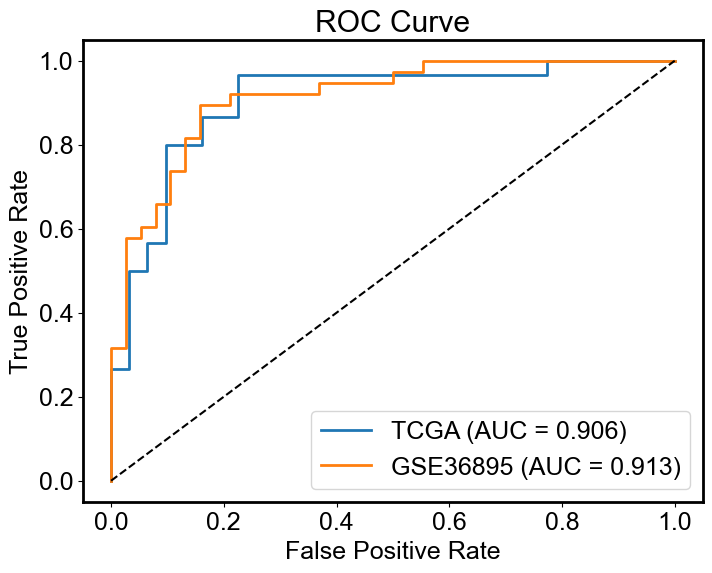

In [11]:
# 计算ROC曲线和AUC
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18

# 创建图形对象
plt.figure(figsize=(8, 6))

# 绘制 ROC 曲线
plt.plot(fpr1, tpr1, label='TCGA (AUC = {:.3f})'.format(auc1),linewidth=2)
plt.plot(fpr2, tpr2, label='GSE36895 (AUC = {:.3f})'.format(auc2),linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')

# 设置标签、标题和图例
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# 获取当前坐标轴对象
ax = plt.gca()

# 修改边框属性
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')

# 保存图像
plt.savefig('roc_curve.pdf', dpi=300, bbox_inches='tight')

# 显示图像
plt.show()